# L2 

his notebook provides a comprehensive guide and a set of scripts to configure and manage a specific network topology for testing L2 forwarding. It covers everything from importing libraries and defining variables to executing the necessary commands to establish the topology and conduct both regular and background traffic tests. Throughout this process, the notebook ensures that the network topology is correctly configured and ready for extensive testing, providing a robust and efficient testing environment.

The topology to be used is as follows.

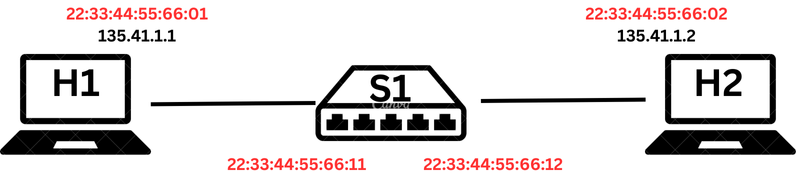

## Create Topology

In this section, we will create the topology shown above. This section should be executed only once, when the slice and the topology have not been previously created.

### Imports

The following code imports essential modules and functions for working with IP addresses, managing a testbed environment, introducing execution delays, and handling JSON data. Specifically, it imports ip_address, IPv4Address, and IPv4Network from the ipaddress module for IP address manipulation, the FablibManager class from the fabrictestbed_extensions.fablib library for testbed management, the sleep function from the time module for pausing program execution, and the json module for working with JSON data.

In [ ]:
from ipaddress import IPv4Address, IPv4Network
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
from time import sleep
import json

### Variables

In this section, we will configure the necessary variables for creating the slice as well as for setting up the network topology.

#### Slice Variables

The code sets up the configuration for a network slice named "L2net", specifying resource allocations for both hosts and switches, as well as designating the sites and the operating system image to be used. Each host is allocated 2 CPU cores, 2 GB of RAM, and 10 GB of disk space, while each switch is allocated 4 CPU cores, 8 GB of RAM, and 10 GB of disk space. The two sites are the CERN, and Altanta (ATLA). Finally the system image configured for use is "default_ubuntu_20".

In [ ]:
# Slice configuration
slice_name = "L2net"  # Slice name

# Hosts configuration
host_cores = 2
host_ram = 2
host_disk = 10
host_site = "ATLA"  # Site name

# Switch configuration
switch_cores = 4
switch_ram = 8
switch_disk = 10
switch_site = "CERN"  # Site name

# Image configuration
image = "default_ubuntu_20"

#### Network Variables

The Python code reads network configuration data from a JSON file located at './utils/network_data.json' and extracts MAC and IP addresses for hosts and switches within different subnets. The decision was made to store the network element configuration information in an external file to provide a personalized learning experience for each student. Since it is a JSON file, the values can be easily understood at a glance.

In [ ]:
file_path = './utils/network_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)
    h1_mac = data['hosts']['h1']['mac']
    h1_ip = data['hosts']['h1']['ip']
    h2_mac = data['hosts']['h2']['mac']
    h2_ip = data['hosts']['h2']['ip']
    switch_mac_1 = data['switches']['s1']['macs'][0]
    switch_mac_2 = data['switches']['s1']['macs'][1]
    subnet = data['subnet']

### Build Topology

In this section we will configure the network nodes, as well as the links that connect them.

#### Create Slice

This Python code initializes a network management object and creates a new network slice. First, it creates an instance of the FablibManager class by calling fablib_manager(), which is stored in the variable fablib. Then, it creates a new network slice with the name specified by slice_name, in this case "L2net" using the new_slice method of the fablib object, and assigns this new slice to the variable slice. This setup allows for the management and configuration of the specified network slice.

In [ ]:
fablib = fablib_manager() # Create a new FablibManager object
slice = fablib.new_slice(name=slice_name) # Create a new slice

#### Create Topology

This Python code sets up a network slice by creating and configuring hosts and switches, adding network interfaces, and establishing connections between them. It defines two hosts (h1 and h2) and one switch, each with specified resources (cores, RAM, disk) and an image (default_ubuntu_20). Each node is assigned interfaces, with hosts having one each and the switch having two. The code then creates Layer 2 networks to connect the interfaces of the hosts and switches, forming the network topology. Finally, it submits the slice configuration and handles any errors that may occur during the process.

In [ ]:
try:
    # Hosts and switch creation
    h1 = slice.add_node(name="h1", site=host_site, cores=host_cores, ram=host_ram, disk=host_disk, image=image)
    h2 = slice.add_node(name="h2", site=host_site, cores=host_cores, ram=host_ram, disk=host_disk, image=image)
    switch = slice.add_node(name="switch", site=switch_site, cores=switch_cores, ram=switch_ram, disk=switch_disk, image=image)
   
    # Interfaces creation
    h1_iface0 = h1.add_component(model='NIC_Basic', name='h1p0').get_interfaces()[0]
    h2_iface0 = h2.add_component(model='NIC_Basic', name='h2p0').get_interfaces()[0]
    switch_iface1 = switch.add_component(model='NIC_Basic', name='s1p1').get_interfaces()[0]
    switch_iface2 = switch.add_component(model='NIC_Basic', name='s1p2').get_interfaces()[0]

    # Switch to the hosts connections
    s1h1 = slice.add_l2network(name='s1h1', interfaces=[switch_iface1, h1_iface0])
    s1h2 = slice.add_l2network(name='s1h2', interfaces=[switch_iface2, h2_iface0])
    
    # Add the nodes to the slice
    slice.submit()
except Exception as e:
    print(f"Error: {e}")

### Install packages

In this section, we will install the necessary packages to ensure all functionalities of the topology work properly. Prior to this, each network node will need to be obtained.

#### Obtain nodes

This Python code retrieves previously created nodes from the network slice. It fetches one switch nodes and two host nodes (h1 and h2) by their names from the slice configuration. These retrieved nodes can then be used for further operations or configurations within the network slice.

In [ ]:
switch = slice.get_node(name="switch")
h1 = slice.get_node(name="h1")
h2 = slice.get_node(name="h2")

#### Install packages in nodes

This Python code installs essential software on network switches and hosts within the slice. It defines commands for installing the P4 behavioral model (bmv2), network tools (net-tools), and the Scapy library. The switch execute commands to install bmv2 and net-tools, while the hosts (h1 and h2) install net-tools and Scapy. Each installation command is executed on the respective nodes, capturing the output and any errors quietly.

In [ ]:
install_bmv2 = '. /etc/os-release && echo "deb https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_${VERSION_ID}/ /" | sudo tee /etc/apt/sources.list.d/home:p4lang.list && curl -L "https://download.opensuse.org/repositories/home:/p4lang/xUbuntu_${VERSION_ID}/Release.key" | sudo apt-key add - && sudo apt-get update && sudo apt install -y p4lang-p4c'
install_net_tools = 'sudo apt-get install -y net-tools'
install_scapy = 'sudo apt-get update && sudo apt-get install -y python3-scapy'

# The switch will install bmv2 and net-tools
stdout, stderr = switch.execute(f'{install_bmv2} && {install_net_tools}', quiet=True)

# The hosts will install net-tools and scapy
stdout, stderr = h1.execute(f'{install_net_tools} && {install_scapy}', quiet=True)
stdout, stderr = h2.execute(f'{install_net_tools} && {install_scapy}', quiet=True)

### Assign IP and MAC addresses

In this section, we will bring up the interfaces so they can be used in the topology and configure the MAC and IPv4 addresses of the nodes. To achieve this, we will first obtain the interfaces of each node.

#### Obtain interfaces

This Python code retrieves and prints the device names of network interfaces for each switch and host within the network slice. For the switch, it gets the interfaces associated with their respective network connections (s1h1 and s1h2) and prints the device names. Similarly, for each host (h1 and h2), it retrieves the interfaces associated with their respective network connections to switches (s1h1, s1h2) and prints their device names. This setup helps in identifying and verifying the network interfaces used in the slice configuration.

In [ ]:
# Switch
switch_iface1 = switch.get_interface(network_name='s1h1')
switch_iface1_name = switch_iface1.get_device_name()
print(f'switch_iface1: {switch_iface1_name}')

switch_iface2 = switch.get_interface(network_name='s1h2')
switch_iface2_name = switch_iface2.get_device_name()
print(f'switch_iface2: {switch_iface2_name}')

# Hosts
h1_iface0 = h1.get_interface(network_name='s1h1')
h1_iface0_name = h1_iface0.get_device_name()
print(f'h1_iface0: {h1_iface0_name}')

h2_iface0 = h2.get_interface(network_name='s1h2')
h2_iface0_name = h2_iface0.get_device_name()
print(f'h2_iface0: {h2_iface0_name}')


#### Turn interfaces up

This Python code brings up the network interfaces for the switch and hosts within the network slice. For the switch, it executes commands to enable (bring up) each of their respective interfaces (s1_iface1_name and s1_iface2_name) using the sudo ip link set dev <interface> up command. Similarly, it brings up the interfaces for each host (h1 and h2) by executing the same command for their respective interfaces. The quiet=True parameter ensures that the command output is not printed, capturing any output or errors in stdout and stderr. This setup ensures all network interfaces are active and ready for communication.

In [ ]:
# Switch
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface1_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface2_name} up', quiet=True)

# Hosts
stdout, stderr = h1.execute(f'sudo ip link set dev {h1_iface0_name} up', quiet=True)
stdout, stderr = h2.execute(f'sudo ip link set dev {h2_iface0_name} up', quiet=True)

#### Configure MAC and IP

This Python code configures the MAC and IP addresses for the interfaces of switches and hosts in a network slice. It sets the MAC addresses for each interface of the switch and hosts (h1 and h2) using the sudo ifconfig <interface> hw ether <mac_address> command, followed by setting the IP addresses for these interfaces using the sudo ifconfig <interface> <ip_address> command.

In [ ]:
# MAC
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} hw ether {switch_mac_1}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} hw ether {switch_mac_2}')
stdout, stderr = h1.execute(f'sudo ifconfig {h1_iface0_name} hw ether {h1_mac}')
stdout, stderr = h2.execute(f'sudo ifconfig {h2_iface0_name} hw ether {h2_mac}')

# IP
stdout, stderr = h1.execute(f'sudo ifconfig {h1_iface0_name} {h1_ip}')
stdout, stderr = h2.execute(f'sudo ifconfig {h2_iface0_name} {h2_ip}')


## Reset Topology

In this section, we will create the following topology to test L2 forwarding. This section should be executed when the topology has already been built and the Python kernel has been restarted to redefine the topology variables.

### Imports

The following code imports essential modules and functions for working with IP addresses, managing a testbed environment, introducing execution delays, and handling JSON data. Specifically, it imports ip_address, IPv4Address, and IPv4Network from the ipaddress module for IP address manipulation, the FablibManager class from the fabrictestbed_extensions.fablib library for testbed management, the sleep function from the time module for pausing program execution, and the json module for working with JSON data.

In [ ]:
from ipaddress import IPv4Address, IPv4Network
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
from time import sleep
import json

### Reset variables, nodes and interfaces

This Python code sets up and retrieves the network configuration for a slice named "L2net". It starts by initializing a FablibManager object and retrieving the slice configuration. It reads MAC and IP address data for hosts and switches from a JSON file. For the switch and for each host (h1 and h2), it extracts the relevant network interface names. The MAC addresses are mapped to interfaces, and the IP addresses are organized by subnets. This setup allows the program to configure the network interfaces and routes accurately, ensuring proper communication within the network slice.

In [ ]:
verbose = 0
slice_name = "L2net"  # Slice name

fablib = fablib_manager()
slice = fablib.get_slice(name=slice_name)

file_path = './utils/network_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)
    h1_mac = data['hosts']['h1']['mac']
    h1_ip = data['hosts']['h1']['ip']
    h2_mac = data['hosts']['h2']['mac']
    h2_ip = data['hosts']['h2']['ip']
    switch_mac_1 = data['switches']['s1']['macs'][0]
    switch_mac_2 = data['switches']['s1']['macs'][1]
    subnet = data['subnet']

switch = slice.get_node(name='switch')
h1 = slice.get_node(name='h1')
h2 = slice.get_node(name='h2')

switch_iface1_name = switch.get_interface(network_name='s1h1').get_device_name()
switch_iface2_name = switch.get_interface(network_name='s1h2').get_device_name()

h1_iface0_name = h1.get_interface(network_name='s1h1').get_device_name()
h2_iface0_name = h2.get_interface(network_name='s1h2').get_device_name()


## SSH commands

This Python code attempts to retrieve the network slice named "L2net" and prints the SSH command for each node within the slice. It iterates over each node, printing its name and corresponding SSH command to facilitate remote access.

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node.get_name()}: {node.get_ssh_command()}")
except Exception as e:
    print(f"Exception: {e}")

## Configure P4

In this section, we will configure the P4 program. First, we will create the P4 configuration files, taking into account the names of the interfaces assigned to each switch. Then, we will send the necessary files for the compilation and configuration of the P4 program to the switches, including the program itself. Finally, we will execute the P4 program and include the match and action tables.

### Configure run_bmv2_switch file

This Python code generates helper scripts for running BMv2 (P4 behavioral model) on one switch. The script compiles a P4 program (program.p4) using the p4c compiler and runs the simple_switch command with the appropriate interfaces, redirecting traffic to the specified ports. This setup automates the process of compiling and executing the P4 program on each switch.

In [ ]:
s_ifaces = {}
switches = [switch]
s_ifaces["switch"] = [switch_iface1_name, switch_iface2_name]
for switch in switches:
    switchname = switch.get_name()
    outfile = "./p4/run_bmv2_" + switchname + ".sh"
    with open(outfile, 'w') as out:
        out.write("#!/bin/bash\n\n")
        out.write("p4c --target bmv2 --arch v1model --std p4-16 ~/program.p4 -o ~\n\n")
        out.write(f"sudo simple_switch -i 1@{s_ifaces[switchname][0]} -i 2@{s_ifaces[switchname][1]} ~/program.json --log-console")
        out.close()

### Upload files

This Python code imports the Uploader class from a module named utils.uploader and creates an instance of the Uploader class, assigning it to the variable up. This instance can now be used to upload the file (second argument) to the node (first argument).

In [ ]:
from utils.uploader import Uploader
up = Uploader()

This Python code uploads the necessary P4 program and script files (`program.p4`, `add_rules_<switch>.sh`, and `run_bmv2_<switch>.sh`) to the switch using the `Uploader` instance. After uploading the files, it executes commands on the switch to change the permissions of the script files, making them executable (`chmod u+x`). This ensures that the P4 program and configuration scripts are properly uploaded and ready to be executed on each switch.

In [ ]:
up.upload("switch", "p4/program.p4")
up.upload("switch", "p4/add_rules_switch.sh")
up.upload("switch", "p4/run_bmv2_switch.sh")
stdout, stderr = switch.execute("chmod u+x run_bmv2_switch.sh && chmod u+x add_rules_switch.sh", quiet=True)

### Run P4

This Python code restarts and configures the BMv2 P4 switch on the switch. It first terminates any existing BMv2 instances using sudo killall simple_switch, then starts the BMv2 switch using the uploaded run_bmv2_<switch>.sh script in a separate thread. It pauses for 5 seconds to allow the switch to initialize, and then executes the add_rules_<switch>.sh script to configure the P4 rules. This ensures that each switch is running the BMv2 P4 switch with the correct settings and rules.

In [ ]:
stdout, stderr = switch.execute("sudo killall simple_switch", quiet=True)
switch.execute_thread("./run_bmv2_switch.sh")
sleep(5)
stdout, stderr = switch.execute("./add_rules_switch.sh", quiet=True)

## Configure Packet I

In this section, we will configure a packet with the EPHeader header using ipywidgets. Each executable cell will configure a header, and to save the values you want to set for that header, it is important to press the button.

### Imports

This Python code installs necessary libraries (scapy, ipywidgets, Pillow, matplotlib) and imports modules for network packet manipulation, interactive widgets, image processing, and plotting. It uses pip3 to install the libraries, and then imports specific utility functions for handling Ethernet, IP, and EPHeader tasks from custom modules, as well as all functions and classes from Scapy for network packet manipulation, and pyplot from matplotlib for creating visualizations.

In [ ]:
!pip3 install scapy ipywidgets Pillow matplotlib
from utils.Ethernet import *
from utils.IP import *
from utils.EPHeader import *
from scapy.all import *
from matplotlib import pyplot as plt

### Headers configuration

Once the necessary packages are installed, we will configure the headers that will compose the packet. To configure them, you need to press the corresponding buttons.

#### Ethernet Header

Now we will configure the Ethernet header by modifying the src and dst fields of this header.

In [ ]:
ethernetheader = ethernet_header_widget()

#### IP Header

Now we will configure the IPv4 header. The field called "protocol" must be set to 147 in order to have the EPHeader header. 

In [ ]:
ipheader = ip_header_widget()

#### EP Header

Finally, we will configure the EPHeader, where the values to be set are as follows.

In [ ]:
epheader = ep_header_widget()

### Final Packet

In the following code, we will assemble the packet with the headers configured by pressing the previous buttons. We will print this packet and finally save it in the file named "./pcap/input.pcap".

In [ ]:
FinalPacket = ethernetheader.packet / ipheader.packet / epheader.packet
FinalPacket.show()
wrpcap("./pcap/input.pcap", FinalPacket)

## Configure Packet II

In this section, we will configure a packet with the EPHeader header using variables. Each executable cell will configure a header.

### Imports

This Python code installs the scapy library and imports essential modules for network packet manipulation and specific utility functions. It first installs scapy using pip3, then imports all functions and classes from scapy.all for comprehensive network packet analysis. Additionally, it imports utility functions from custom modules EPHeader. This setup equips the environment with the necessary tools for advanced network packet manipulation and specific functionalities for EPHeader.

In [ ]:
!pip3 install scapy 
from scapy.all import *
from utils.EPHeader import *

### Headers configuration

Once the necessary packages are installed, we will configure the headers that will compose the packet.

#### Ethernet Header

Now we will configure the Ethernet header by modifying the src and dst fields of this header.

In [ ]:
dst="22:33:44:55:66:11"
src="22:33:44:55:66:01"
type="IPv4"

#### IP Header

Now we will configure the IPv4 header.

In [ ]:
version=4
ihl=5
tos=0x0
len=20
id=0
frag=0
ttl=64
proto=147
chksum=0x0
srcIP="135.41.1.1"
dstIP="135.41.1.2"

#### EP Header

Finally, we will configure the EPHeader, where the values to be set are as follows.

In [ ]:
hawkID=4010
exercise=0
ethernet=0
ipv4=0
ipv6=0
correct=0
info='0'

#### Raw

Next, we will also configure the raw payload of the packet.

In [ ]:
rawValue="Potatoe"

### Final Packet

In the following code, we will assemble the packet with the headers configured before. We will print this packet and finally save it in the file named "./pcap/input.pcap".

In [ ]:
FinalPacket = Ether(src=src, dst=dst, type=type) / IP(version=version, ihl=ihl, tos=tos, len=len, id=id, frag=frag, ttl=ttl, proto=proto, chksum=chksum, src=srcIP, dst=dstIP) / EPHeader(hawkID=hawkID,exercise=exercise, ethernet=ethernet, ipv4=ipv4, ipv6=ipv6, correct=correct, info=info)
FinalPacket.show()
wrpcap("./pcap/input.pcap", FinalPacket)

## Receive and Send Packet

In this section, we will send and receive the previously configured packet.

### Upload files

This Python code imports the Uploader class from a module named utils.uploader and creates an instance of the Uploader class, assigning it to the variable up. This instance can now be used to upload the file (second argument) to the node (first argument).

In [ ]:
from utils.uploader import Uploader
up = Uploader()

This Python code uploads the Python scripts receive.py and send.py to two hosts (h1 and h2) and sets executable permissions for these scripts on each host. This ensures that the scripts are correctly uploaded and ready to be executed on all two hosts for further tasks.

In [ ]:
up.upload("h1", "./utils/send.py")
up.upload("h1", "./utils/receive.py")
#up.upload("h1", "./pcap/input.pcap")
stdout, stderr = h1.execute("chmod u+x receive.py & chmod u+x send.py")
up.upload("h2", "./utils/send.py")
up.upload("h2", "./utils/receive.py")
#up.upload("h2", "./pcap/input.pcap")
stdout, stderr = h2.execute("chmod u+x receive.py & chmod u+x send.py")

This Python code snippet uploads a pcap file named input.pcap to host h1 using the Uploader instance (up).

In [ ]:
up.upload("h1", "./pcap/input.pcap")

This Python code facilitates data transmission and reception between two hosts, h1 and h2, using Python scripts. It starts by running the receive.py script on h2 in a separate thread and pauses for 5 seconds to allow initialization. Then, it executes the send.py script on h1 to send the packet configured before. After a brief 0.1-second pause, it stops all Python processes on h2 to terminate the receiving script. The received data is then retrieved, processed from hex to bytes, reconstructed into a packet using Scapy's Ether class, and displayed for analysis.

In [ ]:
rx_thread = h2.execute_thread("sudo python3 receive.py")
sleep(5)
stdout, stderr = h1.execute("sudo python3 send.py", quiet=True)
sleep(0.1)
stdout, stderr = h2.execute("sudo killall python3", quiet=True)
rx_results = rx_thread.result()[0].split('\n')[1]
packet_bytes = bytes.fromhex(rx_results)
packet_reconstructed = Ether(packet_bytes)
packet_reconstructed.show()

### Download Files

This Python code snippet imports the Downloader class from the utils.downloader module and creates an instance of it, assigned to the variable down. This instance can now be used to download the file (second argument) from the node (first argument).

In [ ]:
from utils.downloader import Downloader
down = Downloader()

This comand uploads a pcap file named output.pcap from host h2 using the Download instance (down). After downloading, this file can be found in the pcap folder.

In [ ]:
down.download("h2", "output.pcap")